In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks.mixture_rw_nd import MixtureRW2D, MixtureRW5D
from markovsbi.tasks.simple_nd import Simple2DStationary
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
key = jax.random.PRNGKey(0)

2025-02-26 16:26:01.145028: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
task = MixtureRW2D()
prior = task.get_prior()
simulator = task.get_simulator()

In [7]:
key, key_task = jax.random.split(key)

In [8]:
data = task.get_data(key_task, 100_000, 2)

In [9]:
sde, weight_fn = init_sde(data)

In [10]:
key, key_init = jax.random.split(key)

In [11]:
from markovsbi.models.train_utils import sample_beta

c_in, c_noise, c_out = precondition_functions(sde, shring_var=0.5)
init_fn, score_net = build_score_mlp(2, hidden_dim=50, num_hidden=5,c_in=c_in, c_noise=c_noise, c_out=c_out, x_o_processing="linear")
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn, control_variate=True, control_variate_optimal_scaling=True)

In [12]:
theta_batch, x_batch = batch_sampler(key_init, 50)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

(50, 2) (50, 2, 2)


In [13]:
x_batch.shape

(50, 2, 2)

In [14]:
params = init_fn(key_init, jnp.ones((50,)), theta_batch, x_batch)

In [15]:

schedule = optax.cosine_onecycle_schedule (
    200_000, 5e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(100.), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [16]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [17]:
for i in range(40):
    l = 0.
    for _ in range(5000):
        key, key_loss, key_batch = jax.random.split(key,3)
        theta_batch, x_batch = batch_sampler(key_batch, 1000)
        loss, params, opt_state = update(params, key_loss, opt_state, theta_batch, x_batch)
        l += loss/5000
    print(l)

13.246782
13.118679
13.11663
13.078734
12.771597
12.355131
12.299873
12.28405
12.322859
12.312327
12.288378
12.304966
12.291328
12.269109
12.302855
12.278213
12.308802
12.242079
12.304325
12.267904
12.23253
12.27523
12.263242
12.241925
12.248874
12.214715
12.265167
12.220565
12.246715
12.21476
12.283766
12.254218
12.287988
12.256926
12.272815
12.222483
12.215781
12.2441635
12.249039
12.247936


In [18]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [19]:
key = jax.random.PRNGKey(2)
theta_o = prior.sample(key)
num_obs = 101
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

num_obs

[-1.0433589   0.71743053]


101

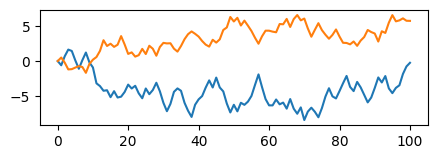

In [20]:
fig = plt.figure(figsize=(5,1.5))
plt.plot(x_o)

In [21]:
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior, posterior_precission_est_fn=None)

In [24]:
score_fn.estimate_hyperparameters(x_o, (2,), key, diag=False, precission_nugget=0.1)

In [25]:

from markovsbi.sampling.sample import Diffuser
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM
from markovsbi.models.utils import get_windows

kernel = EulerMaruyama(score_fn)
length = 500
time_grid = jnp.linspace(sde.T_min, sde.T_max, length)
sampler = Diffuser(kernel, time_grid, (d,))


In [26]:
traces = jax.vmap(sampler.simulate, in_axes=(0,None))(jax.random.split(key,(100,)), x_o)

(-5.0, 5.0)

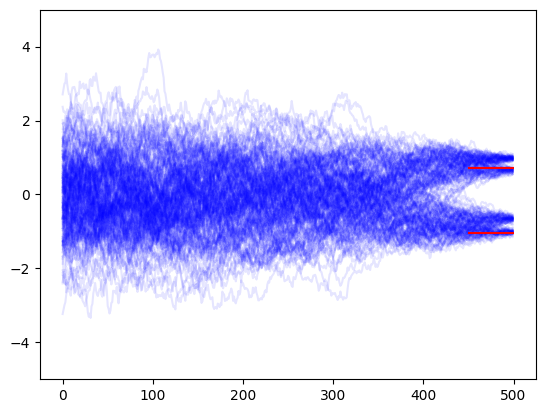

In [27]:
# ???
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, length-length/10, length, color="red")
plt.ylim(-5,5)

In [28]:
samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 1000), x_o)

In [29]:
jnp.sum(samples)

Array(-9.426506, dtype=float32)

Text(0, 0.5, '$\\theta_2$')

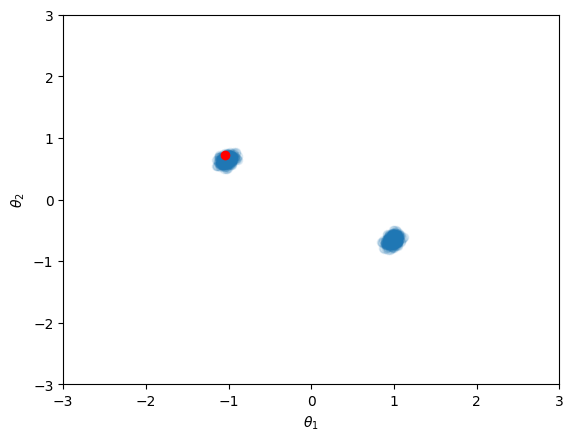

In [30]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.1)
plt.scatter(theta_o[0], theta_o[1], color="red")
plt.ylim(-3,3)
plt.xlim(-3,3)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")


In [31]:
model = task.get_true_posterior(x_o)

In [32]:
thetas = model.sample(jax.random.PRNGKey(0), (1000,))

Text(0, 0.5, '$\\theta_2$')

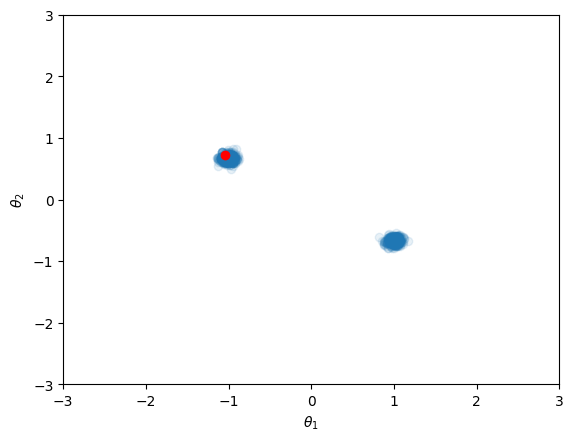

: 

In [ ]:
plt.scatter(thetas[:,0], thetas[:,1], alpha=0.1)
plt.scatter(theta_o[0], theta_o[1], color="red")
plt.ylim(-3,3)
plt.xlim(-3,3)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

In [465]:
from sbi.utils.metrics import c2st
import torch
import numpy as np

c2st(torch.tensor(np.array(samples)), torch.tensor(np.array(thetas)))

tensor(0.7985, dtype=torch.float64)